In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/gender_submission.csv
./input/train.csv
./input/test.csv


# problem description and objective

- problem description: Titanic sank on maiden voyage after colliding with an iceberg, killing 2/3 of the passengers
- objective: predict if a passenger survived or not (binary classification problem)

# data acquisition

- early negotiating data access with stakeholders too reduce risk
- storing the data securely and according to privacy regulations (GDPR)
- spend your time wisely. More data samples? More features? Artificially augment data?

In [2]:
from sklearn.utils import shuffle
df = pd.read_csv("./input/train.csv")
kaggle_competition_data = pd.read_csv("./input/test.csv")

# data exploration using descriptive statistics and visualization

some options:
- find out for each feature: data type
- find out for each feature: numerical, nominal categorical, ordinal categorical
- heat map to find correlations between features and between features and target variable

In [3]:
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
# amount of samples
print(len(df))

891


In [5]:
# data type for each feature
print(df.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [6]:
# df info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## numerical, nominal categorical, ordinal categorical for each feature

numerical:
- age
- fare
- sibsp
- parch

nominal categorical:
- survived
- name
- sex
- ticket
- cabin
- embarked

ordinal categorical:
- pclass

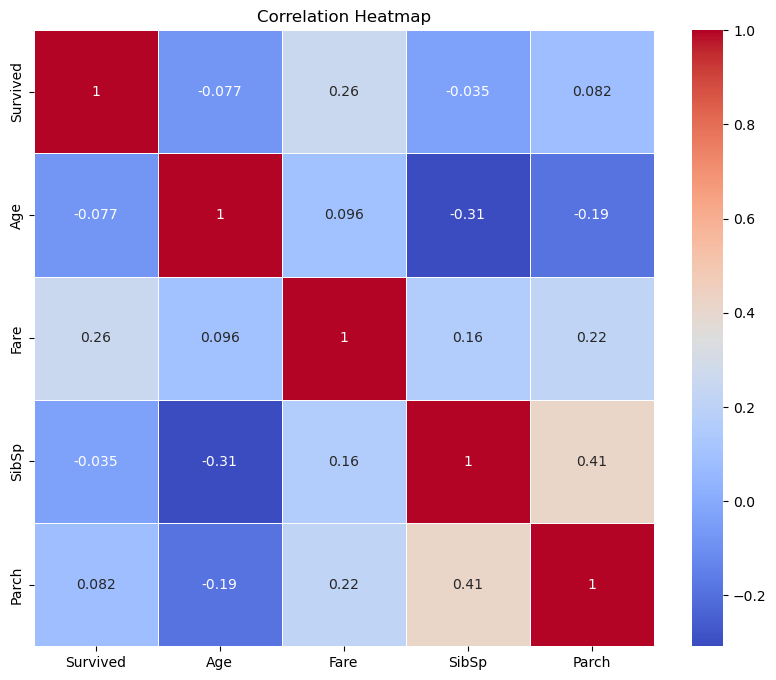

In [7]:
# Calculate the correlation matrix
numerical_features = df[['Survived', 'Age', 'Fare', 'SibSp', 'Parch']]
corr_matrix = numerical_features.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Op het eerste gezicht lijken er geen sterke relaties tussen de features en de overlevingkans

## Univariate analysis op leeftijd

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


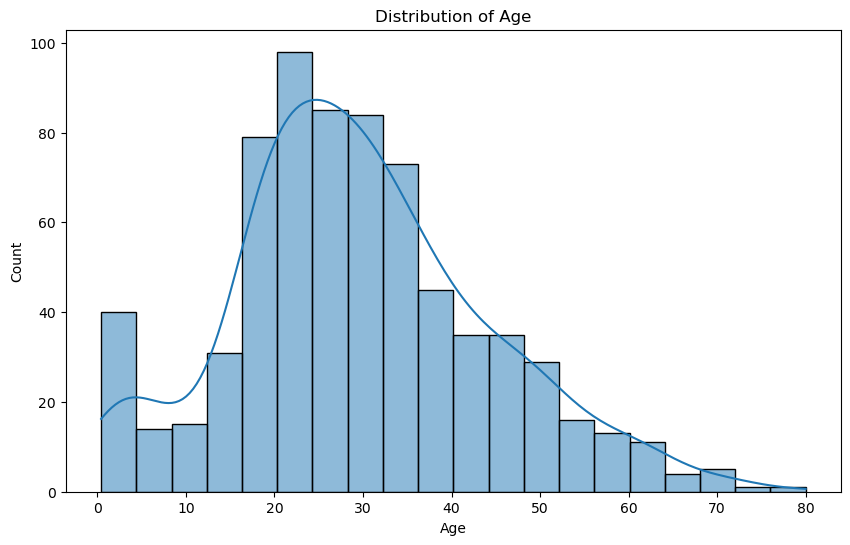

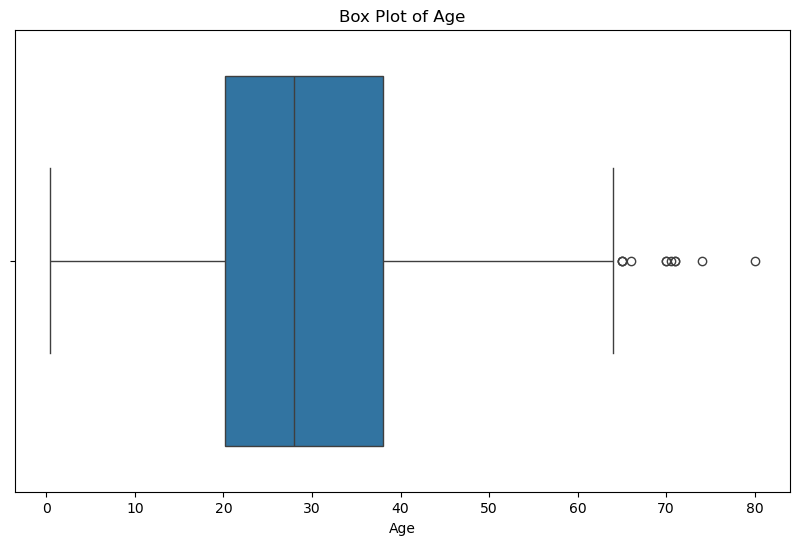

In [8]:
import seaborn as sns

# Descriptive statistics
print(df['Age'].describe())

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Age')
plt.title('Box Plot of Age')
plt.xlabel('Age')
plt.show()

Over het algemeen zijn de passagiers tussen de 20 en 40 jaar oud. Er zijn weinig mensen ouder dan ongeveer 65 jaar.

## Univariate analysis op Sex

Sex
male      577
female    314
Name: count, dtype: int64


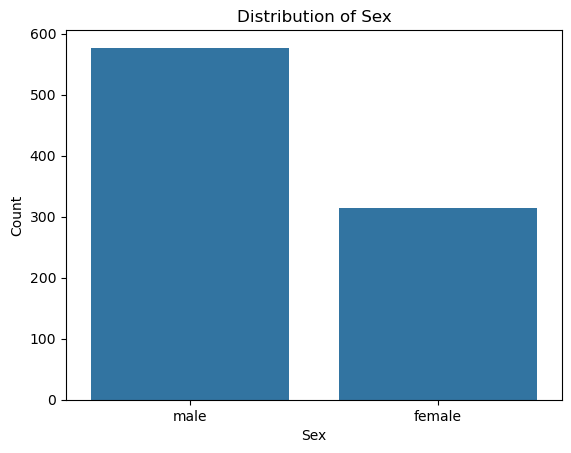

In [9]:
# Count the number of occurrences of each category
sex_counts = df['Sex'].value_counts()

# Print the counts
print(sex_counts)
sns.barplot(x=sex_counts.index, y=sex_counts.values)
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

Er zijn bijna 2x meer mannen dan vrouwen.

## Bivariate analysis op Age en Sex

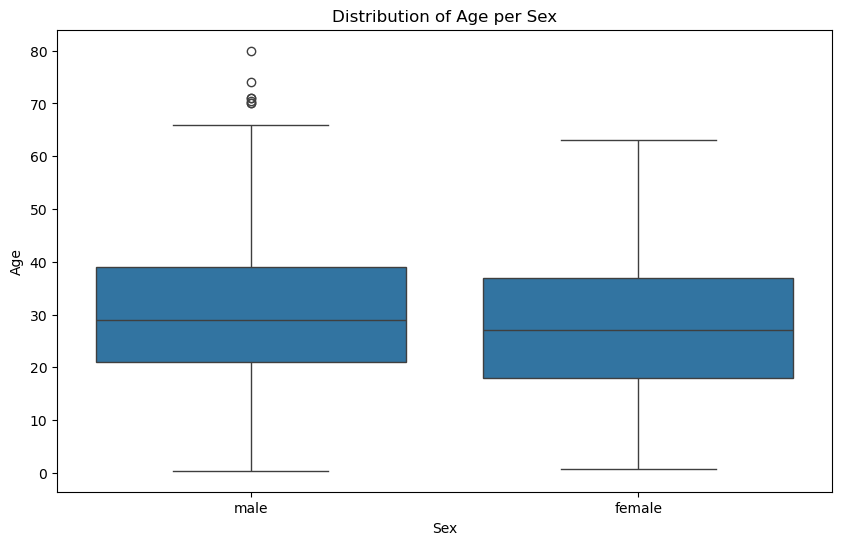

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Sex', y='Age')
plt.title('Distribution of Age per Sex')
plt.xlabel('Sex')
plt.ylabel('Age')
plt.show()

De verdeling van de leeftijd is vergelijkbaar tussen mannen en vrouwen. De mannen hebben een aantal senioren vanaf ongeveer 70 jaar die de vrouwen niet hebben.

# data preprocessing

- dealing with mising data
- encode categorical features as dummy variables

In [11]:
# do not remove samples with missing values. only temporily remove these if you want to check for correlation

print("Before cleansing", len(df))
df.dropna(subset=['Age'], inplace=True)
print("After cleansing", len(df))

# fill in some missing data
# replacing missing age with mean age is probably not very useful
# df_X.fillna({'Cabin':'WAS_NAN_CABIN'}, inplace=True)
# df_X.fillna({'Embarked':'WAS_NAN_EMBARKED'}, inplace=True)

Before cleansing 891
After cleansing 714


# modeling: feature selection

- Niet iedereen zou in de cabine gezeten hebben, dus deze feature (op te zoeken in de ticket) lijkt me niet nuttig.
- Cabin is vaak None, dus sowieso vrij nutteloos
- De klasse is wellicht wel nuttig. Waren de accomodaties op het schip verdeelt, of kwamen alle klassen samen?
- Number of siblings/spouses/etc heeft een nadeel: voor elk persoon met 3 siblings zijn er dus drie andere personen die ook dit getal hebben. Dit getal heeft waarschijnlijk geen impact op Survived, want een persoon met 3 overleeft het misschien, maar zijn/haar broer die ook 3 heeft overleeft het misschien niet.

In [12]:
# Check survival by age and sex
features_X = ['Age', 'Sex', 'Fare', 'Pclass']
feature_y = 'Survived'
df_X = df[features_X]
df_y = df[feature_y]

dummy_sex = pd.get_dummies(df['Sex'], prefix='Sex')
dummy_pclass = pd.get_dummies(df['Pclass'], prefix='Pclass')
df_X = pd.concat([df_X, dummy_sex, dummy_pclass], axis=1)
df_X.drop(['Sex', 'Pclass'], axis=1, inplace=True)
print(df_X.head())

features_X = ['Age', 'Sex_male', 'Sex_female', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3']
feature_y = 'Survived'

    Age     Fare  Sex_female  Sex_male  Pclass_1  Pclass_2  Pclass_3
0  22.0   7.2500       False      True     False     False      True
1  38.0  71.2833        True     False      True     False     False
2  26.0   7.9250        True     False     False     False      True
3  35.0  53.1000        True     False      True     False     False
4  35.0   8.0500       False      True     False     False      True


# modeling: model training

- algorithm selection
- hyperparameter tuning

In [13]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression

# Create the logistic regression model
logreg = LogisticRegression()

# Fit the model to the training data
logreg.fit(X_train, y_train)

# Predict the target variable for the test data
predictions = logreg.predict(X_test)

# Evaluate the model
accuracy = logreg.score(X_test, y_test)

print(f'Accuracy: {accuracy}')

Accuracy: 0.7581395348837209


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

trees_train_rocs = []
trees_test_rocs = []
decision_trees = []
for i in range(1, 31):
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    # cm = metrics.confusion_matrix(y_test, predictions)
    train_roc = metrics.roc_auc_score(y_train, predictions_train)
    test_roc = metrics.roc_auc_score(y_test, predictions_test)
    trees_train_rocs.append([i, train_roc])
    trees_test_rocs.append([i, test_roc])
    decision_trees.append(model)

# cm_labels = ['Dead', 'Alive']
# cm_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

# plt.figure(figsize=(6, 5))
# sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

In [16]:
from sklearn.ensemble import RandomForestClassifier

forests_train_rocs = []
forests_test_rocs = []
forests = []
for i in range(1, 31):
    model = RandomForestClassifier(max_depth=i)
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    # cm = metrics.confusion_matrix(y_test, predictions)
    train_roc = metrics.roc_auc_score(y_train, predictions_train)
    test_roc = metrics.roc_auc_score(y_test, predictions_test)
    forests_train_rocs.append([i, train_roc])
    forests_test_rocs.append([i, test_roc])
    forests.append(model)

# modeling: model evaluation

- choosing evaluation metric

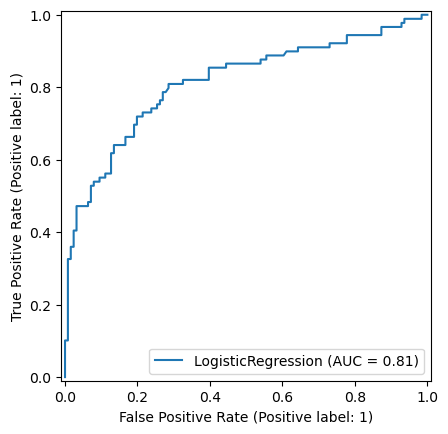

In [17]:
from sklearn.metrics import RocCurveDisplay

# Plot the ROC curve
display = RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.show()

[4, 0.7682807205279115]


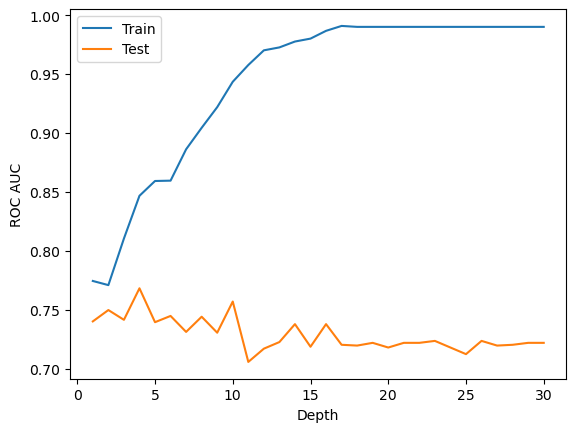

In [18]:
train_rocs_plot = pd.DataFrame(trees_train_rocs, columns=['depth', 'roc'])
test_rocs_plot = pd.DataFrame(trees_test_rocs, columns=['depth', 'roc'])

max_score = max(trees_test_rocs, key=lambda x: x[1])
max_score_index = max_score[0] - 1
print(max_score)

plt.plot(train_rocs_plot['depth'], train_rocs_plot['roc'], label='Train')
plt.plot(test_rocs_plot['depth'], test_rocs_plot['roc'], label='Test')
plt.xlabel('Depth')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

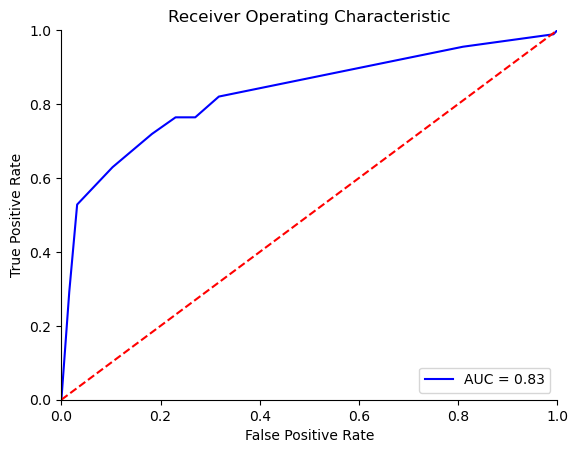

In [19]:
def compute_auroc(truth, prediction):
    fpr, tpr, thresholds = metrics.roc_curve(truth, prediction, pos_label=1)
    return metrics.auc(fpr, tpr)

def plot_auroc(truth, predictions):
    fpr, tpr, threshold = metrics.roc_curve(truth, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def apply_model(model, features, validation_function = compute_auroc):
    pred_tree_test = model.predict_proba(X_test[features])
    pred_survived_tree_test = pd.Series(map(lambda x: x[1], pred_tree_test))
    plot_auroc(y_test, pred_survived_tree_test)

apply_model(decision_trees[max_score_index], X_train.columns)

[13, 0.7993579454253613]


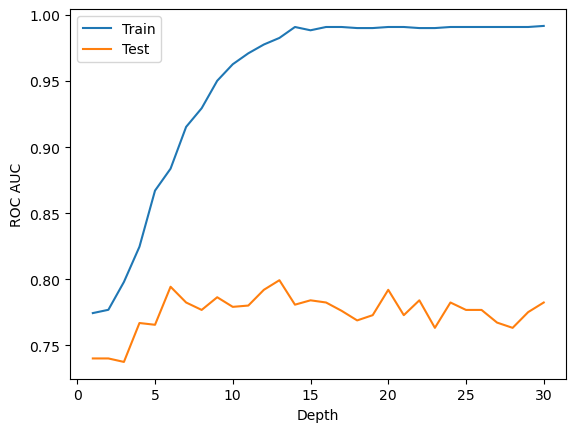

In [20]:
train_rocs_plot = pd.DataFrame(forests_train_rocs, columns=['depth', 'roc'])
test_rocs_plot = pd.DataFrame(forests_test_rocs, columns=['depth', 'roc'])

max_score = max(forests_test_rocs, key=lambda x: x[1])
max_score_index = max_score[0] - 1
print(max_score)

plt.plot(train_rocs_plot['depth'], train_rocs_plot['roc'], label='Train')
plt.plot(test_rocs_plot['depth'], test_rocs_plot['roc'], label='Test')
plt.xlabel('Depth')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

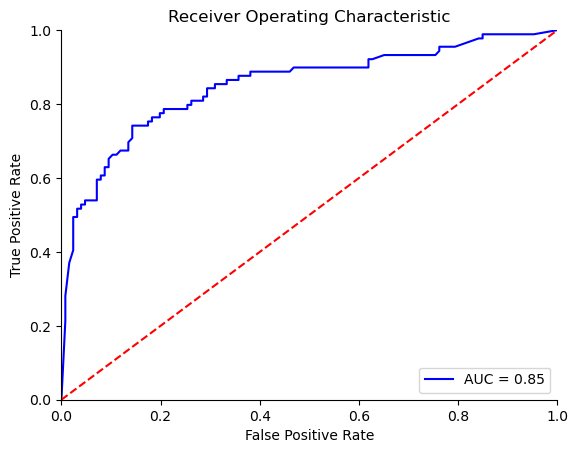

In [21]:
def compute_auroc(truth, prediction):
    fpr, tpr, thresholds = metrics.roc_curve(truth, prediction, pos_label=1)
    return metrics.auc(fpr, tpr)

def plot_auroc(truth, predictions):
    fpr, tpr, threshold = metrics.roc_curve(truth, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def apply_model(model, features, validation_function = compute_auroc):
    pred_tree_test = model.predict_proba(X_test[features])
    pred_survived_tree_test = pd.Series(map(lambda x: x[1], pred_tree_test))
    plot_auroc(y_test, pred_survived_tree_test)

apply_model(forests[max_score_index], X_train.columns)

Het lijkt erop dat de RandomForestClassifier het best presteert; de AUC (area under curve) is daar het hoogst.

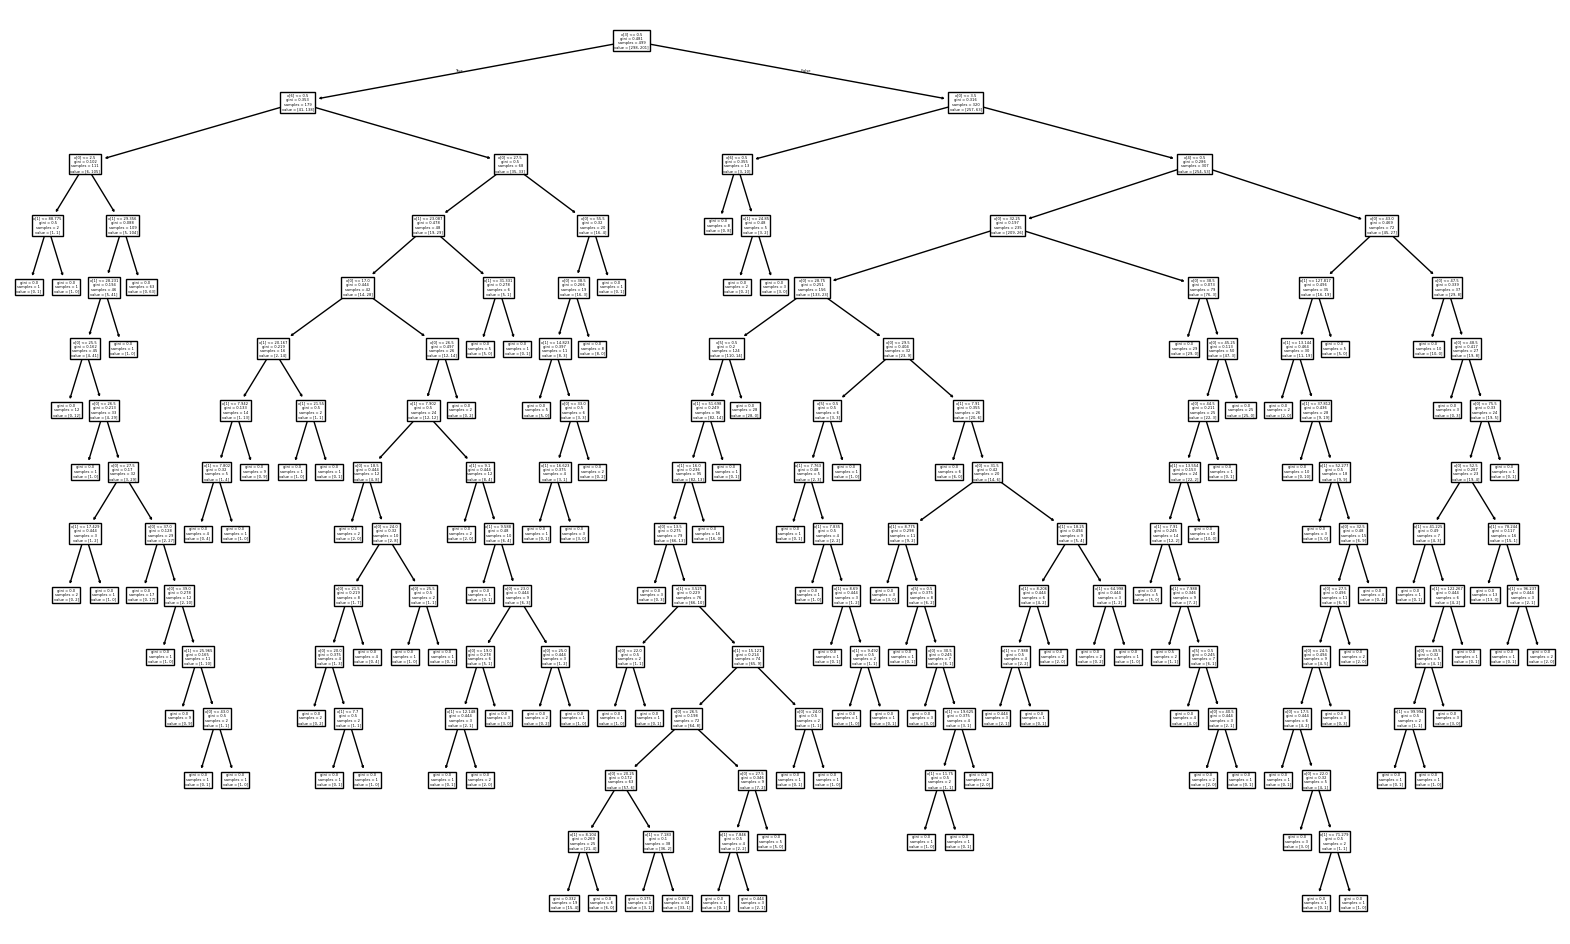

In [22]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,12))
plot_tree(decision_trees[max_score[0]])
plt.show()

Feature ranking:
1. feature 0 Age (0.318151)
2. feature 1 Fare (0.272786)
3. feature 2 Sex_female (0.160548)
4. feature 3 Sex_male (0.136664)
5. feature 6 Pclass_1 (0.052590)
6. feature 4 Pclass_2 (0.036286)
7. feature 5 Pclass_3 (0.022976)


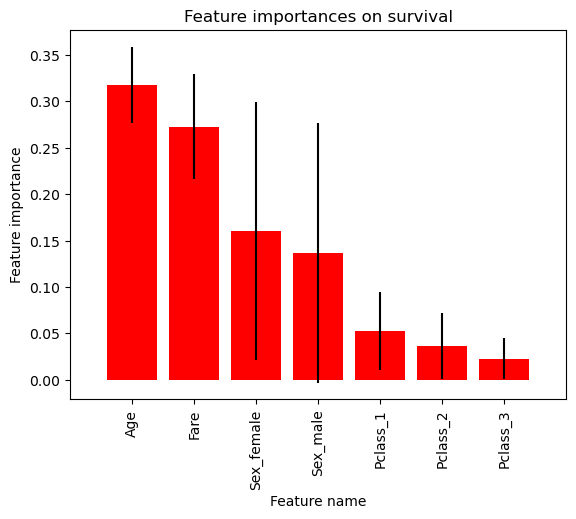

In [23]:
model = forests[max_score_index]
feature_names = model.feature_names_in_
importances = model.feature_importances_

std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = pd.Series(feature_names)

# Print the feature ranking
print("Feature ranking:")

index_features=[]
for f in range(len(feature_names)):
    index_features.append(f)
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], features[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances on survival")
plt.bar(range(len(feature_names)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(feature_names)), features[index_features], rotation = 90)
plt.xlim([-1, len(feature_names)])
plt.xlabel("Feature name")
plt.ylabel("Feature importance")
plt.show()

Het lijkt erop dat het zijn van of vrouw vrij belangrijk is voor de overlevingskans, maar er is veel onduidelijkheid over precies hoe belangrijk.

# Testen op test.csv en gender_submission.csv

In [24]:
df_y = pd.read_csv("./input/gender_submission.csv")

df_X = kaggle_competition_data[['Age', 'Sex', 'Fare', 'Pclass']]

dummy_sex = pd.get_dummies(df_X['Sex'], prefix='Sex')
dummy_pclass = pd.get_dummies(df_X['Pclass'], prefix='Pclass')
df_X = pd.concat([df_X, dummy_sex, dummy_pclass], axis=1)
df_X.drop(['Sex', 'Pclass'], axis=1, inplace=True)

# Evaluate the model on the test data
test_accuracy = model.score(df_X, df_y['Survived'])
print(f'Test Accuracy: {test_accuracy}')

# Predict the target variable for the test data
test_predictions = model.predict(df_X)
test_probabilities = model.predict_proba(df_X)[:, 1]

# Calculate the AUC-ROC score
auc_roc = metrics.roc_auc_score(df_y['Survived'], test_probabilities)
print(f'AUC-ROC Score: {auc_roc}')

Test Accuracy: 0.8325358851674641
AUC-ROC Score: 0.9241318757419865


# deployment of the model

- appify the model
- continuous monitoring of model performance